In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
print tf.__version__

1.9.0


# Fundamentos de TensorFlow

**Expresiones**
- Las expresiones son construidas en términos de **variables** (para los parémetros, como $\theta$) y **placeholders** (para los datos)

- Cuando definimos las expresiones **construimos su grafo simbólico**, pero **no son evaluadas**

- Las expresiones sólo son evaluadas **dentro de una sesión**

- El proceso de **optimización** trata de encontrar valores de las **variables** que minimizan una cierta expresión. 


**Parámetros**
- Las **variables** tienen un tamaño fijo, contienen los parámetros de un modelos, que luego pueden ser salvados o restaurados.

- Las **variables** pueden tener un valor constante, pero normalmente se inicializan con algún valor aleatorio o determinado, y su contenido va variando durante el proceso de optimización.

**Datos**
- Los **placeholders** pueden ser matrices (tensores) con un número fijo de columnas, pero variable de filas, para poder evaluar las expresiones con distintos datasets.

- Los **placeholders** no tienen valores iniciales, y hay que alimentarlos directamente con los datos



**Gradientes**

- TensorFlow calcula automáticamente los gradientes de las expresiones, que los obtiene simbólicamente. Normalmente los gradientes se calculan **respecto a los parámetros** (_placeholders_)


## ¿Qué es el cálculo simbólico?

la máquina manipula algebraicamente las expresiones como lo haríamos nosotros con lápiz y papel

In [2]:
import sympy as sy
sy.init_printing(use_latex=True)
x,y = sy.symbols("x y")

In [3]:
expr = (x+3*y)**2
expr

In [4]:
expr.expand()

derivadas

In [5]:
expr.diff(x)

In [6]:
expr.diff(y)

resolvemos la ecuación cuando $=0$

In [7]:
sy.solve(expr)

pero **todo es simbólico** hasta que **explícitamente lo evaluamos**

In [8]:
expr.subs({x:10, y:2})

integramos simbólicamente

In [9]:
expr.integrate(x)

o evaluamos una integral definida. P.ej, sabemos que:

$$\int_{-1}^1 2\sqrt{1-x^2} = \pi$$

In [10]:
expr = 2*sy.sqrt(1-x**2)
expr

In [11]:
pi = expr.integrate( (x,-1,1))
pi, sy.N(pi)

In [12]:
sy.init_printing(use_latex=False)

## TensorFlow: cálculo simbólico para ML

fíjate cómo en TF se define un grafo (simbólico) y luego se le inyectan valores para evaluarlo


In [13]:
x = tf.Variable(initial_value=tf.random_uniform([2,1]), name="x", dtype=tf.float32)
y = tf.Variable(initial_value=tf.random_uniform([2,1]), name="x", dtype=tf.float32)
expr = x**2+y**2
expr

<tf.Tensor 'add:0' shape=(2, 1) dtype=float32>

In [14]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print sess.run(x)
    print sess.run(y)
    print sess.run(expr)

[[0.21218872]
 [0.78554606]]
[[0.00688422]
 [0.01445711]]
[[0.04507145]
 [0.6172916 ]]


In [15]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print sess.run(expr, feed_dict={x:[[2],[2]], y:[[3],[4]]})

[[13.]
 [20.]]



Las expresiones de ML tienen **muchos parámetros** y en ellas participan **muchos datos**, todo ello mayormente a través de **operaciones con matrices**.

- Los paquetes genéricos de cálculo simbólico (como `sympy`) se vuelven impracticables para los problemas de ML.
- TF está diseñado específicamente como **paquete de cómputo simbólico para problemas de ML**.
    - tratamiento especial de matrices simbólicas
    - distinción entre símbolos para los datos (_placeholders_) y para los parámetros del modelo (_variables_)
- Además permite paralelismo, visualizaciones, etc.

En TensorFlow:

- Hay una **expresión simbólica** que define nuestro problema de ML (el coste o **_loss_**)
- Una **sesión tensorflow** provee un contexto para evaluar expresiones y realizar algoritmos.

Por ejemplo, para nuestro modelo de regresión lineal

- $X \in \mathbb{R}^{m\times 2} = \{\mathbf{x}^{(i)} \in \mathbb{R}^2\}$, datos (**placeholder**)
- $y \in \mathbb{R}^m = \{y^{(i)} \in \mathbb{R}\}$, etiquetas (**placeholder**)
- $\theta \in \mathbb{R}^2$, parámetros (**variable**)


- $\hat{y}^{(i)} = \overline\theta \cdot \mathbf{x}^{(i)}$: predicción del modelo ante la entrada $\mathbf{x}^{(i)}$.

$$J(\overline\theta;X,y) = \frac{1}{m}\sum_{i=0}^{m-1} (\overline\theta \cdot \mathbf{x}^{(i)} - y^{(i)})^2$$


$$\nabla J (\overline\theta; X,y) = \begin{bmatrix}
\frac{\partial J}{\partial \theta_0}\\
\frac{\partial J}{\partial \theta_1}
\end{bmatrix} = \frac{1}{m}2X^{T}\cdot(X\cdot\overline\theta-Y)$$

recuerda que
- $\overline{\theta} = [\theta_0, \theta_1]$
- $\mathbf{x}^{(i)} = [1, x^{(i)}]$

$J$ define nuestro problema de ML (es la función de **_loss_**), y $\nabla J$ es su gradiente que será necesario para encontrar los parámetros $\theta$ que minimizan $J$.

pero con TF no tenemos que calcular $\nabla J$ a mano!!!!



In [16]:
tf.reset_default_graph()
t = tf.Variable(initial_value=tf.random_uniform([2,1]), name="t", dtype=tf.float32)\
   *tf.constant([[40],[20]], dtype=tf.float32)-tf.constant([[5],[10]], dtype=tf.float32)
X = tf.placeholder(name="X", dtype=tf.float32, shape = (None, 2))
y = tf.placeholder(name="y", dtype=tf.float32, shape = (None, 1))
y_hat = tf.matmul(X,t)
loss = tf.reduce_mean(tf.pow(y_hat-y,tf.constant(2, dtype=tf.float32)))

In [17]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter("tmp", sess.graph)


ejecuta

     tensorboard --logdir tmp
    
desde la línea de comando y abre [localhost:6006](http://localhost:6006) para inspeccionar el **grafo computacional** que representa la expresión anterior

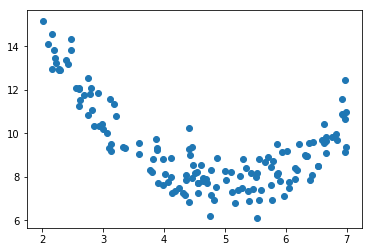

In [18]:
d = pd.read_csv("data/trilotropicos.csv")
X_data = np.r_[[[1]*len(d), d.longitud]].T
y_data = d.densidad_escamas.values
plt.scatter(d.longitud, d.densidad_escamas)

**Evaluamos el costo** (_loss_, $J$) en algún $\theta$ aleatorio, con el grafo computacional de TF, **siempre dentro de una sessión**

In [19]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    t_sample = sess.run(t)
    print "t=", t_sample[:,0]
    print "J=", sess.run(loss, feed_dict={X: X_data, y: y_data.reshape(-1,1)})

t= [-0.89200497  4.7884445 ]
J= 211.88751


evaluación directa

In [20]:
def J(t,X,y):
    return np.mean((X.dot(t)-y)**2)

print "J=", J(t_sample[:,0],X_data,y_data)

J= 211.88750176424185


### gradientes

fíjate ahora cómo usamos TF para que nos calcule **las expresiones** de los gradientes

In [21]:
grad_loss = tf.gradients(loss, t)

In [22]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter("tmp", sess.graph)

observa de nuevo el grafo computacional con **tensorboard**.

**Evaluamos el gradiente** en algún $\theta$ aleatorio

In [23]:
with tf.Session() as sess:
    sess.run(init)
    t_sample = sess.run(t)
    print "t=", t_sample[:,0]
    print "grad J=", sess.run(grad_loss, feed_dict={X: X_data, y: y_data.reshape(-1,1)})[0][:,0]

t= [ 5.0847864 -5.647528 ]
grad J= [ -61.053997 -304.89963 ]


observamos que coincide con la expresión del gradiente derivada manualmente

In [24]:
def n_grad(t,X,y):
    return 2*X.T.dot(X.dot(t)-y)/len(X)

n_grad(t_sample[:,0], X_data, y_data)

array([ -61.05401003, -304.89965277])

## Hacemos nuestra propia implementación de una optimización

### Un gradiente descendiente simple

Fíjate cómo usamos una regla de actualización de parámetros simple:

$$\theta = \theta - 10^{-3} \nabla J$$

In [25]:
t_hist, cost_hist = [], []
with tf.Session() as sess:
    sess.run(init)
    t_current = sess.run(t)
    
    print "init t= ", t_current[:,0]
    t_hist.append(t_current)
    
    for i in xrange(1,3001):
        # parameter update
        grad = sess.run(grad_loss, feed_dict={X: X_data, y: y_data.reshape(-1,1), t: t_current})        
        t_current = t_current - grad[0]*.01
        
        # history
        if i%30==0:
            print ".",
            cost = sess.run(loss, feed_dict={X: X_data, y: y_data.reshape(-1,1), t: t_current})        
            t_hist.append(t_current)
            cost_hist.append(cost)
        
        
print "\nfinal t=", t_current[:,0]

init t=  [31.976433 -4.401524]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
final t= [12.797759  -0.7392324]


compara los parámetros obtenidos con los  óptimos

In [26]:
from sklearn.linear_model import LinearRegression
print "parámetros obtenidos", t_current[:,0]
lr = LinearRegression()
lr.fit(X_data[:,1:],y_data)
print "parámetros óptimos  ", [lr.intercept_, lr.coef_[0]]

parámetros obtenidos [12.797759  -0.7392324]
parámetros óptimos   [12.689998055222224, -0.7180590760985389]


observa cómo obtenemos las predicciones alimentando los valores de $\theta$  obtenidos a una nueva sesión de tenrsorflow

In [27]:
with tf.Session() as sess:
    preds = sess.run(y_hat, feed_dict={t: t_current, X: X_data})[:,0]

In [28]:
nt = t_current[:,0]
print "parámetros obtenidos", nt
print "predicciones     ", preds[:10]
print "valores esperados", y_data[:10]
print "mean abs error   ", np.mean(np.abs(y_data-preds))
print "mean rel error   ", np.mean(np.abs(y_data-preds)/y_data)

parámetros obtenidos [12.797759  -0.7392324]
predicciones      [ 9.975965 11.205019  8.197353  8.437638  8.692785  9.57892   8.074619
  9.583304  9.271976  8.898806]
valores esperados [ 8.81002719 12.98047638  9.50777126  7.81259333  8.81891411  8.07371798
  9.54390404  7.15116822  7.15939183  7.50229833]
mean abs error    1.3821742013484553
mean rel error    0.15099333394872233


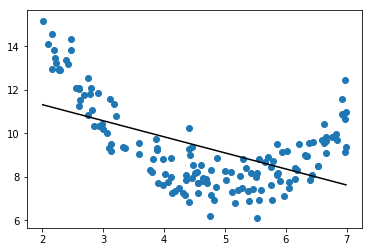

In [29]:
plt.scatter(d.longitud, d.densidad_escamas)
k = np.linspace(np.min(d.longitud), np.max(d.longitud),100)
plt.plot(k, k*nt[1]+nt[0], color="black")

pintamos el proceso que hemos hecho

In [30]:
import itertools
def plot_cost(cost, t0_range, t1_range, vx=None,vy=None):
    k0,k1 = 40,40

    t0 = np.linspace(t0_range[0], t0_range[1], k0)
    t1 = np.linspace(t1_range[0], t1_range[1], k1)

    p = np.zeros((k0,k1))

    for i,j in itertools.product(range(k0), range(k1)):
        p[i,j] = np.log(cost(np.r_[t0[i],t1[j]]))

    plt.contourf(t0, t1, p.T, cmap=plt.cm.hot, levels=np.linspace(np.min(p), np.max(p), 20))
    plt.ylabel(r"$\theta_1$")
    plt.xlabel(r"$\theta_0$")
    plt.title("loss")
    plt.colorbar()

    if vx is not None:
        plt.axvline(vx, color="white")
    if vy is not None:
        plt.axhline(vy, color="white")

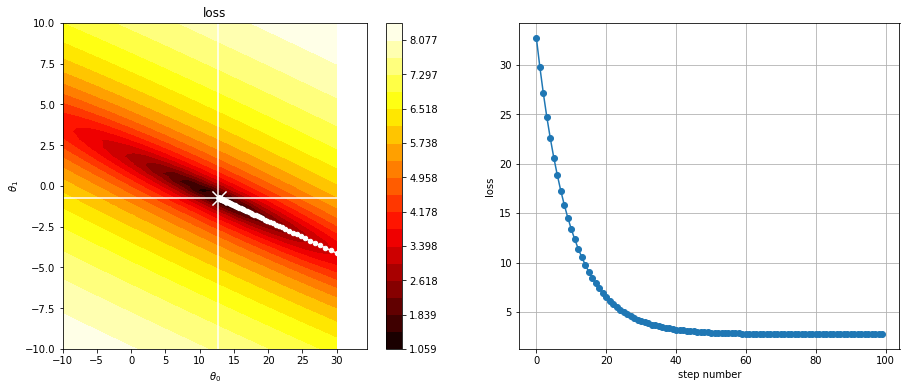

In [31]:
def plot_optimizer(t_hist, cost_hist):
    plt.figure(figsize=(15,6))
    plt.subplot(121)

    loss = lambda t: J(t, X_data, y_data)
    g=np.r_[t_hist][:,:,0]

    plot_cost(loss, (-10,30), (-10,10), vx=lr.intercept_, vy=lr.coef_[0])
    plt.plot(g[:,0], g[:,1], color="white")
    plt.scatter(g[:,0], g[:,1], color="white", s=20)
    plt.scatter(g[-1,0], g[-1,1], marker="x", color="white", s=200)

    plt.subplot(122)
    plt.plot(cost_hist, marker="o")
    plt.xlabel("step number")
    plt.ylabel("loss")
    plt.grid()
plot_optimizer(t_hist, cost_hist)

### Estrategias más elaboradas

TensorFlow nos ofrece varias estrategias de exploración y descenso del gradiente.

### [`GradientDescentOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)

In [32]:
# definimos el grafo computacional
tf.reset_default_graph()
t = tf.Variable(initial_value=tf.random_uniform([2,1]), name="t", dtype=tf.float32)\
   *tf.constant([[40],[20]], dtype=tf.float32)-tf.constant([[5],[10]], dtype=tf.float32)
X = tf.placeholder(name="X", dtype=tf.float32, shape = (None, 2))
y = tf.placeholder(name="y", dtype=tf.float32, shape = (None, 1))
loss = tf.reduce_mean(tf.pow(tf.matmul(X,t)-y,tf.constant(2, dtype=tf.float32)))
init = tf.global_variables_initializer()

# realizamos la optimización
optimizer_gd = tf.train.GradientDescentOptimizer(.00001).minimize(loss)
t_hist, cost_hist = [], []
with tf.Session() as sess:
    sess.run(init)
    t_current = sess.run(t)
    print "init t= ", sess.run(t)[:,0]
    t_hist.append(t_current)
    
    for i in xrange(1,3000):
        # parameter update
        sess.run(optimizer_gd, feed_dict={X: X_data, y: y_data.reshape(-1,1)})
        
        # history
        if i%30==0:
            t_current, cost = sess.run([t, loss], feed_dict={X: X_data, y: y_data.reshape(-1,1)})
            t_hist.append(t_current)
            cost_hist.append(cost)
        
        
    print "final t= ", sess.run(t)[:,0]


init t=  [16.675081  8.930511]
final t=  [12.688156  -0.7176933]


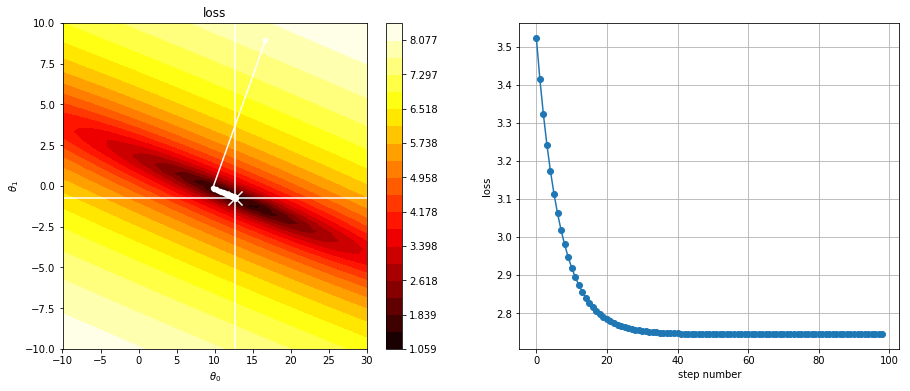

In [33]:
plot_optimizer(t_hist, cost_hist)


### [`AdamOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) y uso de Batches

Observa cómo:

- usamos otro optimizador
- usamos **batches** ya que en general, es más efectivo alimentar al optimizado con _batches_ de datos y no con todo el dataset:

    - **epoch**: un paso por todo el dataset
    - **step**: el procesamiento de un batch
    - **batch_size**: el número de elementos que conforman un batch

- al final de cada **epoch** 
    - muestreamos los parámetros y medimos el coste **con todo el dataset**.
    - verificamos que la función `loss` sigue decayendo significativamente (si no, paramos)

In [34]:
tf.reset_default_graph()
t = tf.Variable(initial_value=tf.random_uniform([2,1]), name="t", dtype=tf.float32)\
   *tf.constant([[40],[20]], dtype=tf.float32)-tf.constant([[5],[10]], dtype=tf.float32)
X = tf.placeholder(name="X", dtype=tf.float32, shape = (None, 2))
y = tf.placeholder(name="y", dtype=tf.float32, shape = (None, 1))
loss = tf.reduce_mean(tf.pow(tf.matmul(X,t)-y,tf.constant(2, dtype=tf.float32)))

optimizer_adam = tf.train.AdamOptimizer().minimize(loss)

init = tf.global_variables_initializer()

n_epochs = 60
batch_size = 2
n = X_data.shape[0]

t_hist, loss_hist = [], []
with tf.Session() as sess:
    sess.run(init)
    t_current = sess.run(t)
    print "init t =  ", sess.run(t)[:,0]
    t_hist.append(t_current)
    
    for epoch in xrange(n_epochs):
        print ".",
        for i in range(n/batch_size+int((n%batch_size)!=0)):
            batch_init, batch_end = i*batch_size, np.min([(i+1)*batch_size, n])
            X_batch, y_batch = X_data[batch_init:batch_end], y_data[batch_init:batch_end]
            k = sess.run(optimizer_adam, feed_dict={X: X_batch, y: y_batch.reshape(-1,1)})

        # history
        t_current, nloss = sess.run([t, loss], feed_dict={X: X_data, y: y_data.reshape(-1,1)})
        t_hist.append(t_current)
        loss_hist.append(nloss)
        if len(loss_hist)>2 and loss_hist[-2]-loss_hist[-1]<5e-3:
            print "small loss, stopping iteration"
            break
        
    print "final t = ", sess.run(t)[:,0]

init t =   [ 9.06713  -9.558098]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . final t =  [14.319279 -1.019248]


(0, 40)

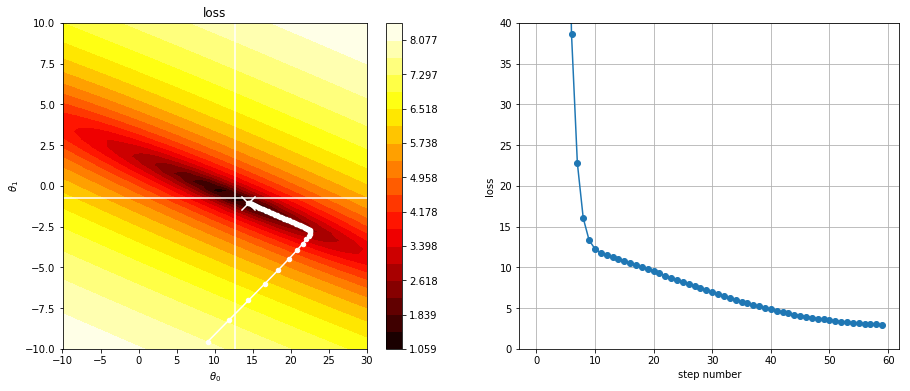

In [35]:
plot_optimizer(t_hist, loss_hist)
plt.ylim(0,40)